## Imports

In [16]:
from src.analysis.basic_graph_analyzer import BasicGraphAnalyzer
from src.analysis.centrality_analyzer import CentralityAnalyzer
from src.analysis.scale_free_analyzer import ScaleFreeAnalyzer
from src.analysis.graph_community_analyzer_graph_tool import GraphCommunityAnalyzerGraphTool

from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

from graph_tool.all import load_graph, GraphView, graph_draw, prop_to_size
from graph_tool import openmp_set_num_threads

## Initialize Graphs

In [17]:
openmp_set_num_threads(8)



# 'Artificial intelligence' not yet done
graph_names = ['Amiga_CD32_games', 'Machine_learning','Game_Boy_games']

graphs = [{"graph_name": graph_name, "graph": load_graph('outputs/graphs/{}.gt'.format(graph_name))} for graph_name in graph_names]


In [18]:
for graph_instance in graphs:
    print(f"-------------Graph: {graph_instance['graph_name']}-------------")
    num_nodes = graph_instance['graph'].num_vertices()
    num_edges = graph_instance['graph'].num_edges()

    print(f"Number of nodes: {num_nodes}")
    print(f"Number of edges: {num_edges}")


-------------Graph: Amiga_CD32_games-------------
Number of nodes: 8013
Number of edges: 1537410
-------------Graph: Machine_learning-------------
Number of nodes: 75217
Number of edges: 26149964
-------------Graph: Game_Boy_games-------------
Number of nodes: 8953
Number of edges: 4095265


## Community detection

In [19]:
graph_comm = graphs[0]['graph']
graph_name = graphs[0]['graph_name']

graph_community_analyzer = GraphCommunityAnalyzerGraphTool(graph_comm, 'outputs/graphs/{}_communities.png'.format(graph_name))
graph_community_analyzer.calc_minimize_blockmodel_dl()



In [20]:
print(f"communities {graph_community_analyzer.communities}")

print(f"type {type(graph_community_analyzer.communities['communities_modularity'].get_array())}")

property_map_communities = graph_community_analyzer.communities['communities_modularity'].get_array()

#print number of distinct communities
print(f"Number of distinct communities: {len(set(property_map_communities))}")
print(f"Len of communities: {len(property_map_communities)}")





communities {'communities_modularity': <VertexPropertyMap object with value type 'int32_t', for Graph 0x7f1bf3be8810, at 0x7f1c57382750>}
type <class 'graph_tool.PropertyArray'>
Number of distinct communities: 374
Len of communities: 8013


## visualize biggest 5 communities

Biggest communities: [(np.int32(1773), 705), (np.int32(4673), 314), (np.int32(1138), 288), (np.int32(2747), 213), (np.int32(1562), 212)]
len community_bool_filter: 8013
community_bool_filter: [False  True False  True  True  True  True False  True  True]
property_map_communities: [3516 1773 3913 1773 1773 1773 1773 5013 1773 1773]
all values with True in community_bool_filter: [1773 1773 1773 ... 4673 1562 1773]
type of community_bool_filter: <class 'numpy.bool'>
count of community_bool_filter True values: 1732
color_map_from_biggest_communities_indexes {np.int32(1773): '#729fcf', np.int32(4673): '#cfb372', np.int32(1138): '#cf7272', np.int32(2747): '#a172cf', np.int32(1562): '#72cfa7'}
vcolor type: <class 'graph_tool.VertexPropertyMap'>
filter_mask type: <class 'graph_tool.VertexPropertyMap'>
vcolor: #000000


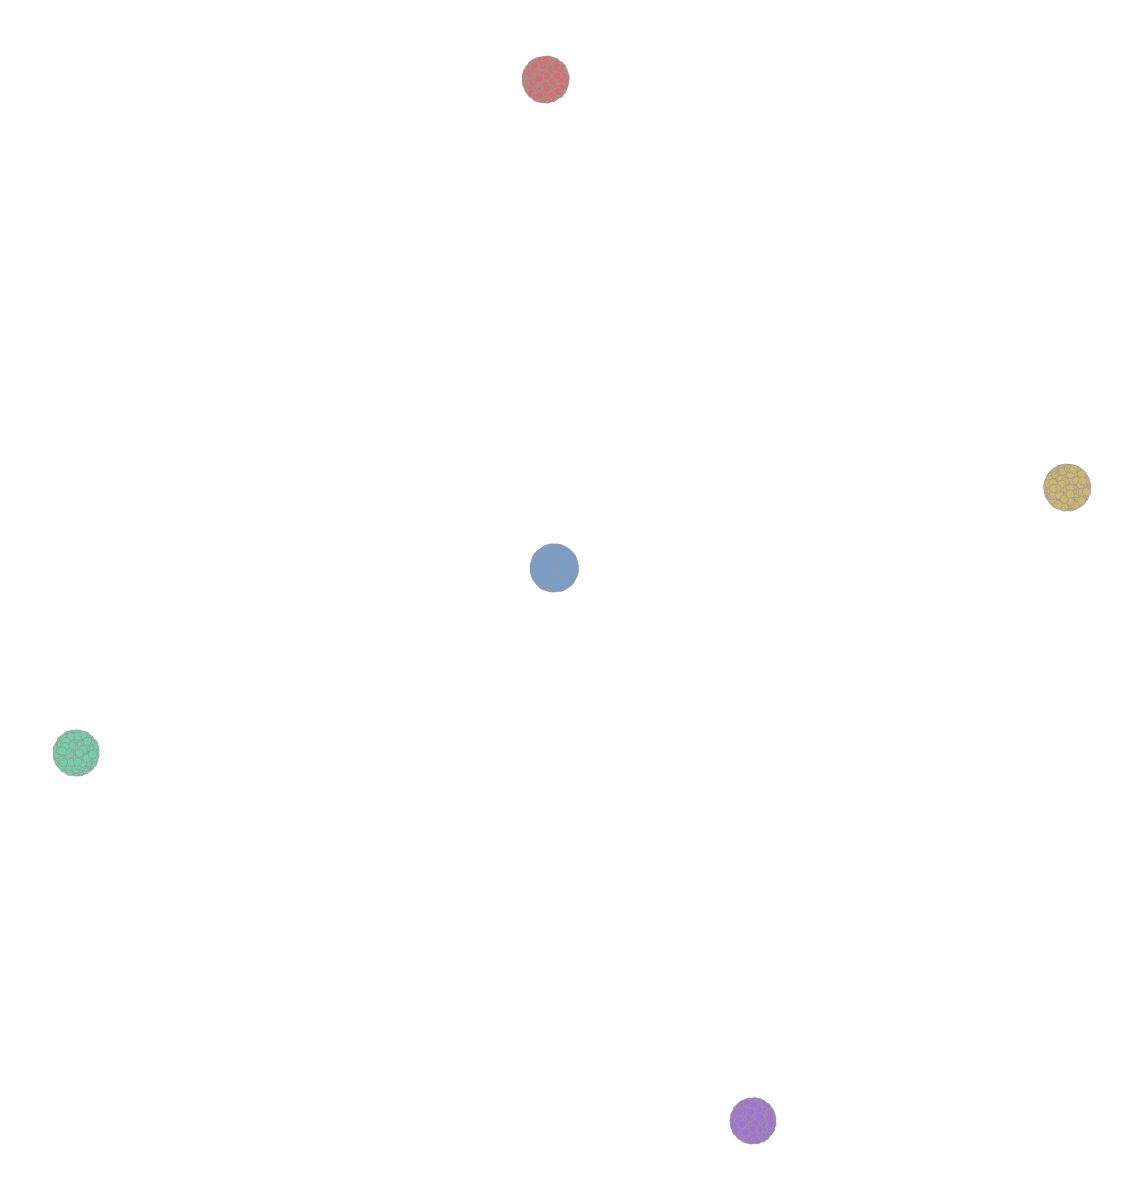

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f1bd881ef10, at 0x7f1bd8b2ab10>

In [39]:
# just visualize biggest 5 communities

#find biggest 5 communities in property_map_communities array


communities = Counter(property_map_communities)
biggest_communities = communities.most_common(5)
print(f"Biggest communities: {biggest_communities}")

community_bool_filter = np.where(property_map_communities == biggest_communities[0][0], True, False)
# community_bool_filter = np.where(property_map_communities == biggest_communities[0][0], True, False)
for i in range(1, 5):
    community_bool_filter = np.logical_or(community_bool_filter, np.where(property_map_communities == biggest_communities[i][0], True, False))
print(f"len community_bool_filter: {len(community_bool_filter)}")
print(f"community_bool_filter: {community_bool_filter[:10]}")
print(f"property_map_communities: {property_map_communities[:10]}")

print(f"all values with True in community_bool_filter: {property_map_communities[community_bool_filter]}")

print(f"type of community_bool_filter: {type(community_bool_filter[0])}")
print(f"count of community_bool_filter True values: {np.count_nonzero(community_bool_filter)}")

filter_mask = graph_community_analyzer.graph.new_vertex_property('bool', vals=community_bool_filter)

# graph_community_analyzer.graph.set_vertex_filter(filter_mask)

# color mapping for communities
color_map = {0: '#729fcf', 1: '#cfb372', 2: '#cf7272', 3: '#a172cf', 4: '#72cfa7'}
color_map_from_biggest_communities_indexes = {biggest_communities[i][0]: color_map[i] for i in range(5)}

print(f"color_map_from_biggest_communities_indexes {color_map_from_biggest_communities_indexes}")

vcolor = graph_community_analyzer.graph.new_vp("string") 

print(f"vcolor type: {type(vcolor)}")
print(f"filter_mask type: {type(filter_mask)}")

for v in graph_community_analyzer.graph.vertices():
    if graph_community_analyzer.graph.vertex_index[v] in np.where(community_bool_filter)[0]:
        vcolor[v] = color_map_from_biggest_communities_indexes[property_map_communities[graph_community_analyzer.graph.vertex_index[v]]]

# fill all vcolor values with black if not in filter_mask
for v in graph_community_analyzer.graph.vertices():
    if vcolor[v] == "":
        vcolor[v] = '#000000'

u = GraphView(graph_community_analyzer.graph, vfilt=filter_mask)
graph_draw(u, vertex_fill_color=vcolor)






## Visualize smallest 5 communities

Smallest communities: [(np.int32(730), 1), (np.int32(6270), 1), (np.int32(6257), 1), (np.int32(2885), 1), (np.int32(4704), 1)]
len community_bool_filter: 8013
community_bool_filter: [False False False False False False False False False False]
property_map_communities: [3983 4632 5178 4632 4632 4632 4632 2012 4632 4632]
all values with True in community_bool_filter: [4704 2885 6257 6270  730]
type of community_bool_filter: <class 'numpy.bool'>
count of community_bool_filter True values: 5


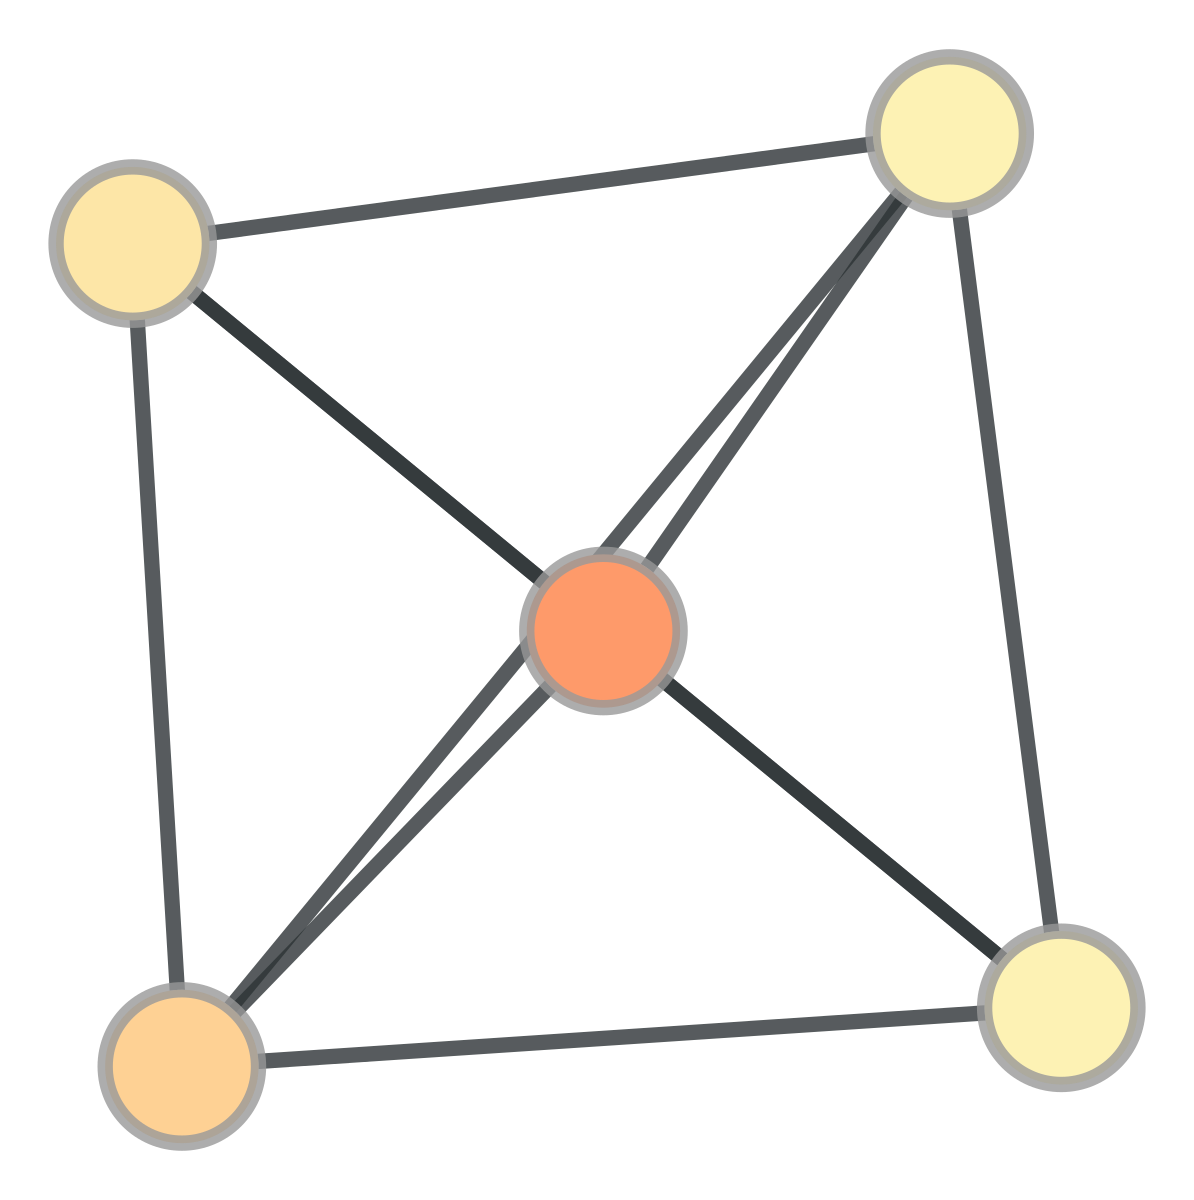

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f1bf3bc6290, at 0x7f1bf3bbb950>

In [14]:
# visualize smallest 5 communities
smallest_communities = communities.most_common()[:-6:-1]
print(f"Smallest communities: {smallest_communities}")

community_bool_filter = np.where(property_map_communities == smallest_communities[0][0], True, False)
# community_bool_filter = np.where(property_map_communities == biggest_communities[0][0], True, False)
for i in range(1, 5):
    community_bool_filter = np.logical_or(community_bool_filter, np.where(property_map_communities == smallest_communities[i][0], True, False))
print(f"len community_bool_filter: {len(community_bool_filter)}")
print(f"community_bool_filter: {community_bool_filter[:10]}")
print(f"property_map_communities: {property_map_communities[:10]}")

print(f"all values with True in community_bool_filter: {property_map_communities[community_bool_filter]}")

print(f"type of community_bool_filter: {type(community_bool_filter[0])}")
print(f"count of community_bool_filter True values: {np.count_nonzero(community_bool_filter)}")

filter_mask = graph_community_analyzer.graph.new_vertex_property('bool', vals=community_bool_filter)

# graph_community_analyzer.graph.set_vertex_filter(filter_mask)

u = GraphView(graph_community_analyzer.graph, vfilt=filter_mask)
graph_draw(u, vertex_fill_color=prop_to_size(graph_community_analyzer.communities['communities_modularity'], 0,1, power=.1))
